# Plotting for NAS-Bench-Suite predictors

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [268]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import kendalltau
matplotlib.rcParams['pdf.fonttype'] = 42

11/14: added extra matrix experiments for the rebuttal. 
BBO has a lot more weird nan issues than pred, so I made some adjustments.

This notebook is similar to plot_pred_nov12.ipynb but with black-box optimizer (NAS) 
results instead of performance predictor results.

plot_pred_nov12.ipynb is slightly cleaner and better commented than this notebook.


In [3]:
# method that gathers all of the results

# example result path:
# ~/results_nas_bench_suite/bbo_results_oct1/bbo_results_oct1_0/nasbench201/cifar100/npenas/config_28/7

# and the result dict structure:
# results_dict[28][nb201_c10][npenas] = [np.mean(values), np.std(values)]

def get_hpo_results(optimizers, search_spaces, root):
    errors = 0
    results_dict = {}
    root = os.path.expanduser(root)
    for seed_header in os.listdir(root):
        for search_space in search_spaces:
            for optimizer in optimizers:
                optimizer_path = os.path.join(root, seed_header, file_dict[search_space], optimizer)
                if not os.path.exists(optimizer_path):
                    continue
                for hpo_folder in os.listdir(optimizer_path):
                    hpo_seed = int(hpo_folder.split('_')[-1])
                    values = []
                    for seed in os.listdir(optimizer_path + '/' + hpo_folder):
                        result_path = optimizer_path + '/' + hpo_folder + '/' + seed + '/errors.json'
                        if not os.path.isfile(result_path):
                            continue
                        result = json.load(open(result_path))
                        valid_accs = result[1]['valid_acc']
                        value = np.max(valid_accs)
                        if not np.isnan(value):
                            continue
                        values.append(value)
                    if len(values) > 3:
                        # had to add these if statements because file structure is in a different order
                        if hpo_seed not in results_dict:
                            results_dict[hpo_seed] = {}
                        if search_space not in results_dict[hpo_seed]:
                            results_dict[hpo_seed][search_space] = {}
                        if optimizer not in results_dict[hpo_seed][search_space]:
                            results_dict[hpo_seed][search_space][optimizer] = {}
                        results_dict[hpo_seed][search_space][optimizer] = [np.mean(values), np.std(values)]
                    else:
                        print(len(values), 'not enough values', hpo_seed, search_space, optimizer)
                        errors += 1
                        if errors < 100:
                            continue
                        print('ending early due to excess errors')
                        return results_dict
    return results_dict

In [56]:
# Define constants that will be used throughout the notebook

"""
Set up colors. There are 11 colors defined in 'defaults', and 3 markers/formats for the plot lines.
So there are 33 color/markers total.
"""
defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            (0.0, 0.0, 0.0)
           ]

fmts = ['-', '--', ':', '-.']
markers = ['^', 'v', 'o']
defaults = [np.array(d) for d in defaults]
# TODO: adapt this for multi-fidelity
color_dict={
    'rs':{'color':defaults[0], 'fmt':fmts[0]},
    're':{'color':defaults[1], 'fmt':fmts[0]},
    'ls':{'color':defaults[2], 'fmt':fmts[0]},
    'bananas':{'color':defaults[3], 'fmt':fmts[0]},
    'npenas':{'color':defaults[4], 'fmt':fmts[0]},
}

# https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html

# how the optimizer names will be displayed in the plot legends:
# TODO: adapt this for multi-fidelity
pred_label_dict={
    'rs': 'Rand. Search', 're':'Reg. Evo.', 'ls':'Local Search', 
    'bananas':'BANANAS', 'npenas':'NPENAS'
}

In [232]:
# search space constants

# how the search space name will be displayed in the plot titles:
# TODO: adapt this for multi-fidelity
ss_dict_lined = {'nb101':'NB-101\n CIFAR10', 
                 'nb201_c10':'NB-201\n CIFAR10', 
                 'nb201_c100':'NB-201\n CIFAR100', 
                 'nb201_im':'NB-201\n ImageNet', 
                 'darts':'DARTS\n CIFAR10',
                 'nlp':'NB-NLP\n TreeBank',
                 'asr':'NB-ASR\n TIMIT',
                 'mr_3ddet':'NB-MR\n KITTI',
                 'mr_cls':'NB-MR\n ImageNet',
                 'mr_seg':'NB-MR\n City',
                 'mr_video':'NB-MR\n HMDB51',
                 'transmicro_obj':'TNB-Micro\n Object', 
                 'transmicro_scene':'TNB-Micro\n Scene', 
                 'transmicro_jigsaw':'TNB-Micro\n Jigsaw', 
                 'transmicro_room':'TNB-Micro\n Room',
                 'transmicro_segment':'TNB-Micro\n Semantic', 
                 'transmicro_normal':'TNB-Micro\n Surface', 
                 'transmicro_auto':'TNB-Micro\n Autoenc.', 
                 'transmacro_obj':'TNB-Macro\n Object', 
                 'transmacro_scene':'TNB-Macro\n Scene', 
                 'transmacro_jigsaw':'TNB-Macro\n Jigsaw', 
                 'transmacro_room':'TNB-Macro\n Room',
                 'transmacro_segment':'TNB-Macro\n Semantic', 
                 'transmacro_normal':'TNB-Macro\n Surface', 
                 'transmacro_auto':'TNB-Macro\n Autoenc.', 
          }
# TODO: adapt this for multi-fidelity
ss_dict_oneline = {'nb101':'NB-101 CIFAR10', 
                 'nb201_c10':'NB-201 CIFAR10', 
                 'nb201_c100':'NB-201 CIFAR100', 
                 'nb201_im':'NB-201 ImageNet', 
                 'darts':'DARTS CIFAR10',
                 'nlp':'NB-NLP TreeBank',
                 'asr':'NB-ASR TIMIT',
                 'mr_3ddet':'NB-MR KITTI',
                 'mr_cls':'NB-MR ImageNet',
                 'mr_seg':'NB-MR City',
                 'mr_video':'NB-MR HMDB51',
                 'transmicro_obj':'TNB-Micro Object', 
                 'transmicro_scene':'TNB-Micro Scene', 
                 'transmicro_jigsaw':'TNB-Micro Jigsaw', 
                 'transmicro_room':'TNB-Micro Room',
                 'transmicro_segment':'TNB-Micro Semantic', 
                 'transmicro_normal':'TNB-Micro Surface', 
                 'transmicro_auto':'TNB-Micro Autoenc.', 
                 'transmacro_obj':'TNB-Macro Object', 
                 'transmacro_scene':'TNB-Macro Scene', 
                 'transmacro_jigsaw':'TNB-Macro Jigsaw', 
                 'transmacro_room':'TNB-Macro Room',
                 'transmacro_segment':'TNB-Macro Semantic', 
                 'transmacro_normal':'TNB-Macro Surface', 
                 'transmacro_auto':'TNB-Macro Autoenc.', 
          }

# these are the filenames as of sep24
# TODO: adapt this for multi-fidelity
file_dict = {
    'nb101':'nasbench101/cifar10', 
    'nb201_c10':'nasbench201/cifar10', 
    'nb201_c100':'nasbench201/cifar100', 
    'nb201_im':'nasbench201/ImageNet16-120', 
    'darts':'darts/cifar10', 
    'nlp':'nlp/LM-task', 
    'asr':'asr/TIMIT', 
    'transmicro_obj':'transbench101_micro/class_object',
    'transmicro_scene':'transbench101_micro/class_scene',
    'transmicro_jigsaw':'transbench101_micro/jigsaw',
    'transmicro_room':'transbench101_micro/room_layout',
    'transmicro_segment':'transbench101_micro/segmentsemantic',
    'transmicro_normal':'transbench101_micro/normal',
    'transmicro_auto':'transbench101_micro/autoencoder',
    'transmacro_obj':'transbench101_macro/class_object',
    'transmacro_scene':'transbench101_macro/class_scene',
    'transmacro_jigsaw':'transbench101_macro/jigsaw',
    'transmacro_room':'transbench101_macro/room_layout',
    'transmacro_segment':'transbench101_macro/segmentsemantic',
    'transmacro_normal':'transbench101_macro/normal',
    'transmacro_auto':'transbench101_macro/autoencoder',
    'mr_3ddet':'mr/3ddet',
    'mr_cls':'mr/cls',
    'mr_seg':'mr/seg',
    'mr_video':'mr/video',
            }
# TODO: adapt this for multi-fidelity
ss_dict_mat = {'nb101':'NB-101', 
                 'nb201_c10':'NB-201', 
                 'nb201_c100':'NB-201', 
                 'nb201_im':'NB-201', 
                 'darts':'DARTS',
                 'nlp':'NB-NLP',
                 'asr':'NB-ASR',
                 'mr_3ddet':'NB-MR',
                 'mr_cls':'NB-MR',
                 'mr_seg':'NB-MR',
                 'mr_video':'NB-MR',
                 'transmicro_obj':'TNB-Micro', 
                 'transmicro_scene':'TNB-Micro', 
                 'transmicro_jigsaw':'TNB-Micro', 
                 'transmicro_room':'TNB-Micro',
                 'transmicro_segment':'TNB-Micro', 
                 'transmicro_normal':'TNB-Micro', 
                 'transmicro_auto':'TNB-Micro', 
                 'transmacro_obj':'TNB-Macro', 
                 'transmacro_scene':'TNB-Macro', 
                 'transmacro_jigsaw':'TNB-Macro', 
                 'transmacro_room':'TNB-Macro',
                 'transmacro_segment':'TNB-Macro', 
                 'transmacro_normal':'TNB-Macro', 
                 'transmacro_auto':'TNB-Macro', 
          }

# Now load all of the data
 - Each algorithm is tagged as "algorithm_date" and then later we can pick which ones we want to plot
 - The next cell will create a dictionary will all of the results from the specified search space

In [6]:
# do not accidentally run this twice.
# takes >30 min to load all these results
if True:
    search_spaces = ['nb101', 'nb201_c10', 'nb201_c100', 'nb201_im', 'darts', 'asr', 'nlp',
                     'transmicro_obj', 'transmicro_scene', 'transmicro_jigsaw', 
                     'transmicro_room', 'transmicro_segment', 'transmicro_normal', 
                     'transmicro_auto', 
                     'transmacro_obj', 'transmacro_scene', 'transmacro_jigsaw', 
                     'transmacro_room', 'transmacro_segment', 'transmacro_normal', 
                     'transmacro_auto', 'mr_cls', 'mr_3ddet', 'mr_seg', 'mr_video']
    optimizers=('rs', 're', 'ls', 'bananas', 'npenas')
    root = '~/plotting_data/bbo'
    results_dicts = {}

    results = get_hpo_results(optimizers, search_spaces, root=root)

In [7]:
# compute how many of each we have
print(len(results.keys()))
keys = results.keys()
keys = list(keys)
keys.sort()
print(keys)

100
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [197]:
ss_group_full = ['nb101', 'nb201_c10', 'nb201_c100', 'nb201_im', 'darts', 'asr', 'nlp',
                 'mr_3ddet', 'mr_video', 'mr_cls', 'mr_seg',
            'transmicro_obj', 'transmicro_scene', 'transmicro_jigsaw', 
            'transmicro_room', 'transmicro_segment', 'transmicro_normal', 'transmicro_auto', 
            'transmacro_obj', 'transmacro_scene', 'transmacro_jigsaw', 
            'transmacro_room', 'transmacro_segment', 'transmacro_normal', 'transmacro_auto']

# Now plot everything

In [435]:
result_folder = 'plots_nov10/'
# specify the seed that represents the default config:
default_config = 0

In [224]:
# plot default and hpo side by side
def plot_default_hpo(results, ss_group, optimizers, offset=0.1, scale_type='0-1', one_line=False, label=False, save=None):

    if not one_line:
        plot_width = .7 * len(ss_group)
    else:
        plot_width = .42 * len(ss_group)        
    fig, ax = plt.subplots(figsize=(plot_width,2))
    width = 0
    ss_order = []
    for search_space in ss_group:
        if one_line:
            ss_order.append(ss_dict_oneline[search_space])
        else:
            ss_order.append(ss_dict_lined[search_space])
        width += 1
        means = []
        for optimizer in optimizers:
            mean = results[default_config][search_space][optimizer][0]
            means.append(mean)

            hpo_means = []
            for hpo_seed in results.keys():
                if optimizer not in results[hpo_seed][search_space]:
                    continue
                hpo_means.append(results[hpo_seed][search_space][optimizer][0])
            mean = np.max(hpo_means)
            means.append(mean)

        #print(search_space, means[::2])
        if scale_type == '0-1':
            min_acc, max_acc = np.min(means), np.max(means)
            means = [(m - min_acc) / (max_acc - min_acc) for m in means]

        i = 0
        for optimizer in optimizers:
            color = color_dict[optimizer]['color']
            
            # to average nbmr
            first, second = i, i+1
            if optimizer == 'rs' and 'mr' in search_space:
                second = i

            if width == 1:
                ax.scatter(width-offset, means[first], label=pred_label_dict[optimizer], color=color, marker='o')
                ax.scatter(width+offset, means[second], label=pred_label_dict[optimizer]+'+HPO', color=color, marker='x')
            else:
                ax.scatter(width-offset, means[first], color=color, marker='o')    
                ax.scatter(width+offset, means[second], color=color, marker='x')
            i = i + 2

    ax.set_xticks(range(1, len(ss_order)+1))
    if label:
        ax.set_xticklabels(ss_order, fontsize=12, rotation=90)
    else:
        ax.set_xticklabels(['' for _ in range(len(ss_order))], fontsize=12, rotation=90)

    if one_line:
        ax.legend(loc=(1.01,-.37))
    else:
        ax.legend(loc=(1.01,0))
    #ax.set_xlabel('NAS Benchmark Task', fontsize=14)    
    ax.set_ylabel('Scaled Accuracy', fontsize=12)   
    #ax.set_title('Scaled Accuracy of NAS Algorithms', fontsize=14)
    ax.set_title('NAS Algorithms', fontsize=14)
    
    if save:
        plt.savefig(result_folder + save, bbox_inches = 'tight', pad_inches = 0.1)

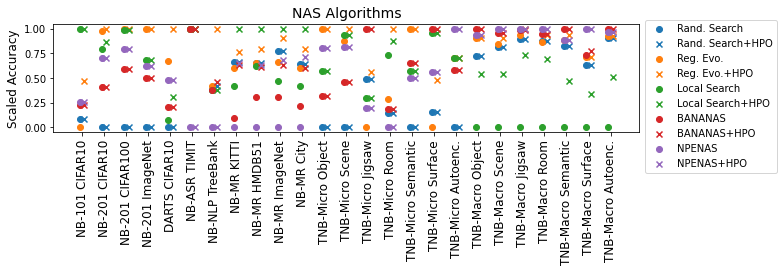

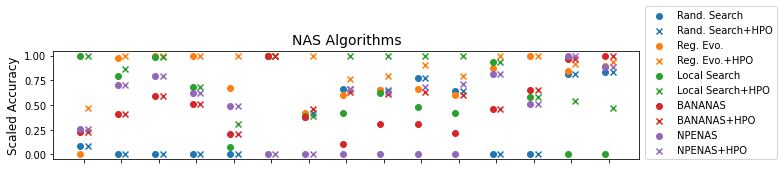

In [225]:
plot_default_hpo(results, ss_group_full, optimizers, scale_type='0-1', one_line=True, label=True) #, save='optimizers_appendix.pdf')

ss_group = ['nb101', 'nb201_c10', 'nb201_c100', 'nb201_im', 'darts', 'asr', 'nlp', \
            'mr_3ddet', 'mr_video', 'mr_cls', 'mr_seg', \
            'transmicro_scene', 'transmicro_segment', 'transmacro_scene', 'transmacro_segment']

plot_default_hpo(results, ss_group, optimizers, scale_type='0-1', label=False) #, save='optimizers.pdf')